# Predicting Credit Card Fraud


## Goal
- Produce a predictive model of fraudulent credit card transactions as evaluated by Area Under the Precision-Recall Curve and Average Precision Score.

## Data
- Taken from here: https://www.kaggle.com/mlg-ulb/creditcardfraud
- Other info:
    > Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

## Process
- Explore Data.
- Split data into validation/training/test sets.
- Select best model based on validation data.
- Evaluate model and perform threshold tuning.
- Perform Bayesian Optimization for hyperparameter tuning.
- Evaluate tuned model and perform threshold tuning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('fivethirtyeight')

In [2]:
data = pd.read_csv('./data/creditcard.csv')

## Exploring data
Let's go through the basics and explore this dataset.

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [5]:
compare_means = pd.concat([
    data[data['Class'] == 0].mean().round(3),
    data[data['Class'] == 1].mean().round(3)
], axis = 1)

compare_means.columns = ['Legit','Fraud']

compare_means['AbsVar'] = abs(compare_means['Fraud'] - compare_means['Legit'])

compare_means['AbsPct'] = (compare_means['AbsVar'] / compare_means['Legit']).round(3) * 100


In [6]:
compare_means.sort_values(by='AbsVar', ascending=False)

,Legit,Fraud,AbsVar,AbsPct
Time,94838.202,80746.807,14091.395,14.9
Amount,88.291,122.211,33.920,38.4
V3,0.012,-7.033,7.045,58708.3
V14,0.012,-6.972,6.984,58200.0
V17,0.012,-6.666,6.678,55650.0
V12,0.011,-6.259,6.270,57000.0
V10,0.010,-5.677,5.687,56870.0
V7,0.010,-5.569,5.579,55790.0
V1,0.008,-4.772,4.780,59750.0
V4,-0.008,4.542,4.550,-56875.0


In [7]:
compare_std = pd.concat([
    data[data['Class'] == 0].std().round(3),
    data[data['Class'] == 1].std().round(3)
], axis = 1)

compare_std.columns = ['Legit','Fraud']

compare_std['Var'] = compare_std['Fraud'] - compare_std['Legit']

compare_std['AbsPct'] = (compare_std['Var'] / compare_std['Legit']).round(3) * 100

compare_std.columns = ['{}_std'.format(i) for i in compare_std.columns]


In [8]:
compare_std.sort_values(by='AbsPct_std', ascending=False)

,Legit_std,Fraud_std,Var_std,AbsPct_std
V17,0.749,6.971,6.222,830.7
V7,1.179,7.207,6.028,511.3
V8,1.161,6.798,5.637,485.5
V21,0.717,3.869,3.152,439.6
V12,0.946,4.654,3.708,392.0
V3,1.459,7.111,5.652,387.4
V14,0.897,4.279,3.382,377.0
V10,1.044,4.897,3.853,369.1
V16,0.845,3.865,3.020,357.4
V5,1.357,5.372,4.015,295.9


In [9]:
compare_mean_and_std = pd.concat([
    compare_means,
    compare_std
], axis = 1)

In [10]:
compare_mean_and_std

,Legit,Fraud,AbsVar,AbsPct,Legit_std,Fraud_std,Var_std,AbsPct_std
Time,94838.202,80746.807,14091.395,14.9,47484.016,47835.365,351.349,0.7
V1,0.008,-4.772,4.780,59750.0,1.930,6.784,4.854,251.5
V2,-0.006,3.624,3.630,-60500.0,1.636,4.291,2.655,162.3
V3,0.012,-7.033,7.045,58708.3,1.459,7.111,5.652,387.4
V4,-0.008,4.542,4.550,-56875.0,1.399,2.873,1.474,105.4
V5,0.005,-3.151,3.156,63120.0,1.357,5.372,4.015,295.9
V6,0.002,-1.398,1.400,70000.0,1.330,1.858,0.528,39.7
V7,0.010,-5.569,5.579,55790.0,1.179,7.207,6.028,511.3
V8,-0.001,0.571,0.572,-57200.0,1.161,6.798,5.637,485.5
V9,0.004,-2.581,2.585,64625.0,1.089,2.501,1.412,129.7


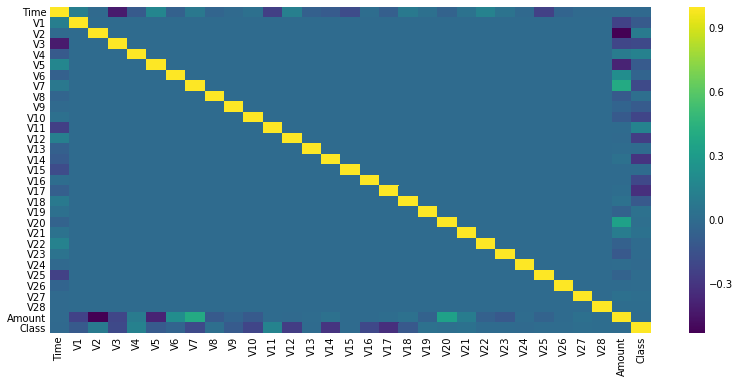

In [11]:
plt.figure(figsize=(12,6))
sns.heatmap(data.corr(),cmap='viridis')

In [12]:
# Custom script; work can be seen in MyDataTools.py available in the same repo as this notebook
from MyDataTools import explore

In [13]:
e = explore()

-----
Col Name: Amount
Total values: 284807
Floor: -493.430 (0 values; 0.00%)
Cap: 670.129 (5935 values; 2.08%)


C:\Users\wband\OneDrive\Documents\github\research\MyDataTools.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_use[col] = df_use[col] if cap_floor is None else self.set_cap_floor(df_use[col])


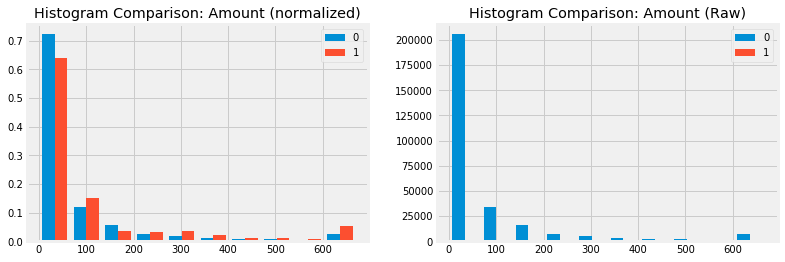

Raw Hist:
               0      1
0.00    205600.0  315.0
67.01    34307.0   74.0
134.03   15780.0   18.0
201.04    7711.0   16.0
268.05    5079.0   17.0
335.06    3422.0   10.0
402.08    2193.0    5.0
469.09    1929.0    6.0
536.10    1371.0    4.0
603.12    6923.0   27.0

Norm Hist:
            0      1
0.00    0.723  0.640
67.01   0.121  0.150
134.03  0.056  0.037
201.04  0.027  0.033
268.05  0.018  0.035
335.06  0.012  0.020
402.08  0.008  0.010
469.09  0.007  0.012
536.10  0.005  0.008
603.12  0.024  0.055

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: Time
Total values: 284807
Floor: -15643.568 (0 values; 0.00%)
Cap: 205271.287 (0 values; 0.00%)


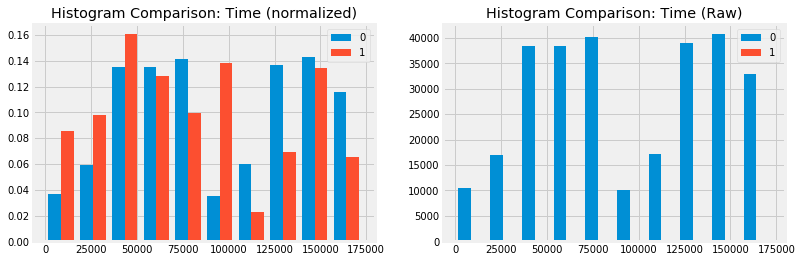

Raw Hist:
                0     1
0.0       10468.0  42.0
17279.2   16907.0  48.0
34558.4   38447.0  79.0
51837.6   38487.0  63.0
69116.8   40194.0  49.0
86396.0   10077.0  68.0
103675.2  17150.0  11.0
120954.4  38917.0  34.0
138233.6  40713.0  66.0
155512.8  32955.0  32.0

Norm Hist:
              0      1
0.0       0.037  0.085
17279.2   0.059  0.098
34558.4   0.135  0.161
51837.6   0.135  0.128
69116.8   0.141  0.100
86396.0   0.035  0.138
103675.2  0.060  0.022
120954.4  0.137  0.069
138233.6  0.143  0.134
155512.8  0.116  0.065

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V1
Total values: 284807
Floor: -4.556 (6233 values; 2.19%)
Cap: 4.556 (0 values; 0.00%)


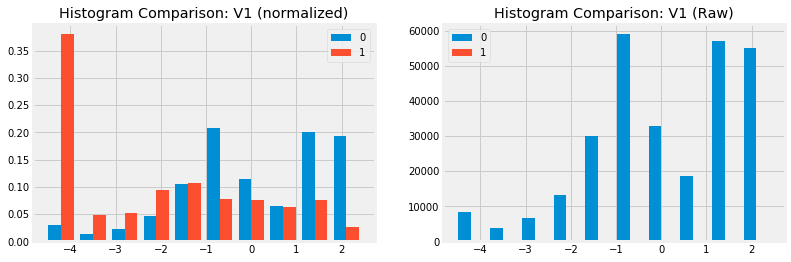

Raw Hist:
             0      1
-4.56   8394.0  187.0
-3.85   3676.0   24.0
-3.15   6653.0   26.0
-2.45  13097.0   46.0
-1.75  29886.0   53.0
-1.05  59042.0   38.0
-0.35  32738.0   37.0
 0.35  18643.0   31.0
 1.05  57014.0   37.0
 1.75  55172.0   13.0

Norm Hist:
           0      1
-4.56  0.030  0.380
-3.85  0.013  0.049
-3.15  0.023  0.053
-2.45  0.046  0.093
-1.75  0.105  0.108
-1.05  0.208  0.077
-0.35  0.115  0.075
 0.35  0.066  0.063
 1.05  0.201  0.075
 1.75  0.194  0.026

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64



In [14]:
# Compare the normalized and raw distributions of all features
# This allows us to get a sense of how distinct each feature is between the classes in the dataset.
e.compare_hists(df=data, target_col='Class', specific_cols=['Amount','Time','V1'], cap_floor=True)

## Data Check
- Null values?
- Normalizing?
- Incorrect values?
- Possibility of feature engineering?

In [15]:
data.Class.sum()

492

In [16]:
len(data.Class)

284807

In [17]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [18]:
# from sklearn.preprocessing import StandardScaler

# S = StandardScaler()

# data['Time_scaled'] = S.fit_transform(X=data[['Time']])
# data['Amount_scaled'] = S.fit_transform(X=data[['Amount']])

In [19]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Seems like everything's there. That makes things easy. Let's get weird.

In [20]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from xgboost import XGBClassifier

In [21]:
X = data.drop(columns=['Class'])
y = data.Class

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train)

In [23]:
from MyDataTools import model

m = model()

rf0 = RandomForestClassifier(n_estimators=50)

xgb = XGBClassifier()

gb0 = GradientBoostingClassifier(n_estimators=50)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


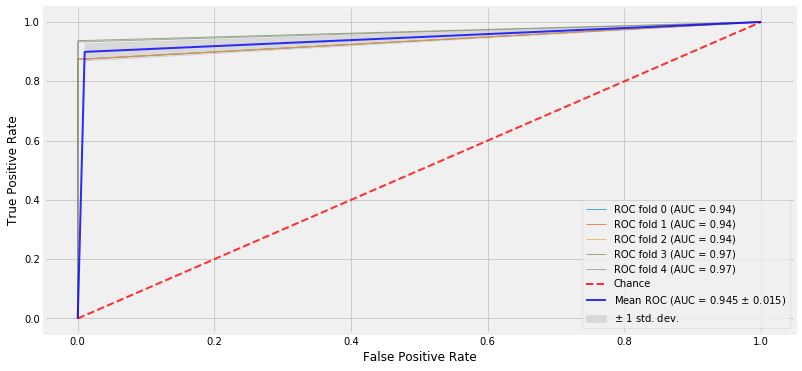

-----

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


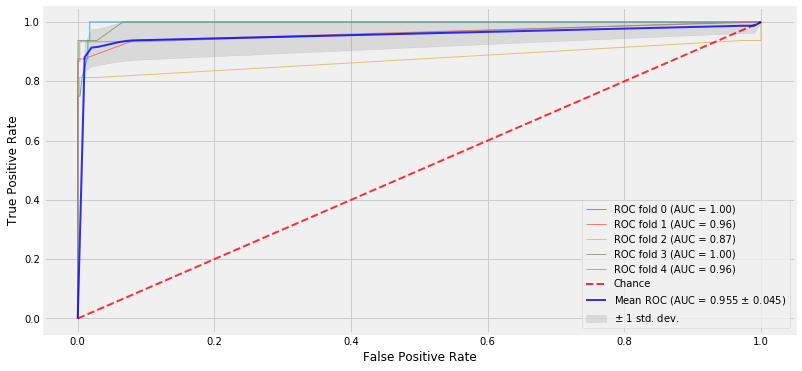

-----

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)


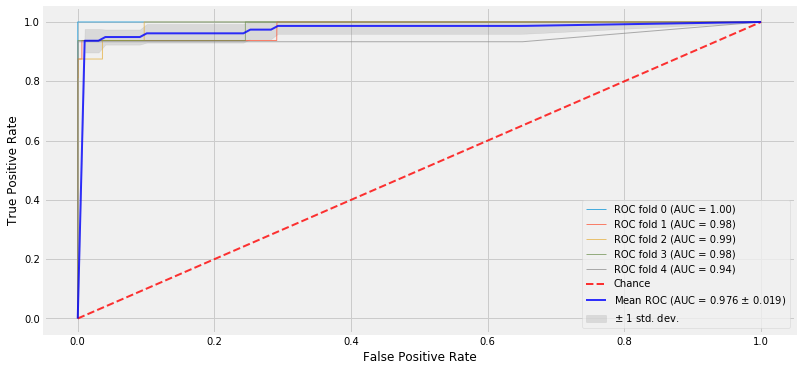

-----



In [24]:
m.cross_val_roc_auc_plot([rf0, gb0, xgb], xval = X_val, yval = y_val)

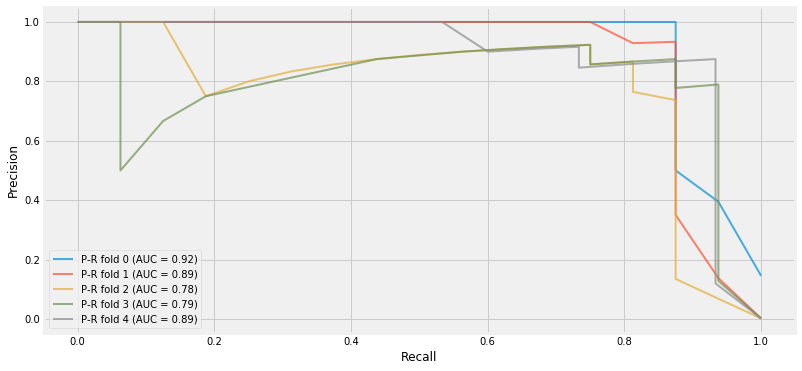

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Avg. Area Under P-R Curve: 0.854 (+/-0.058)
Avg. Precision Score: 0.850 (+/-0.053)
-----



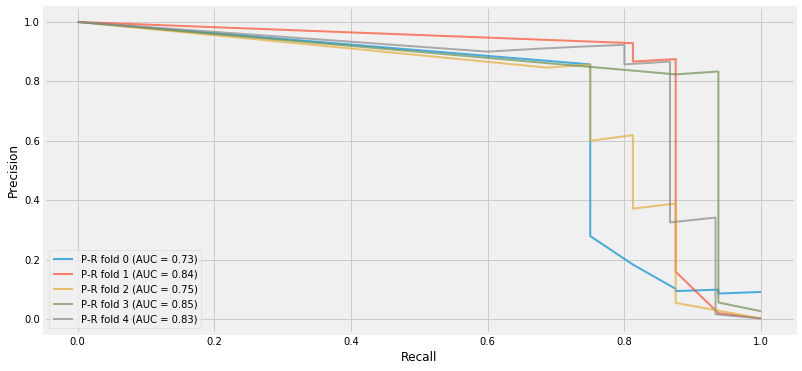

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Avg. Area Under P-R Curve: 0.803 (+/-0.050)
Avg. Precision Score: 0.752 (+/-0.056)
-----



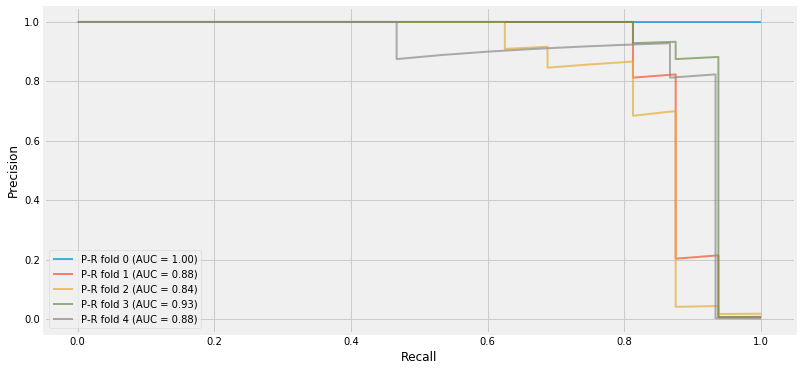

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)
Avg. Area Under P-R Curve: 0.905 (+/-0.056)
Avg. Precision Score: 0.906 (+/-0.055)
-----



In [25]:
m.cross_val_precision_recall_auc([rf0, gb0, xgb], xval = X_val, yval = y_val)

In [26]:
# Based on the above, the XGBClassifier had higher and more stable AUC, which means it has high ability to classify each class.
# The Random Forest Classifier had the most skill in detecting fraudulent transactions.
# We'll go with the XGBC as we want to accurately classify transactions overall.

xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [27]:
preds = xgb.predict(X_test)

In [28]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.82      0.88        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.98      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



In [29]:
print(confusion_matrix(y_test, preds))

[[56860     4]
 [   18    80]]


In [30]:
probas = xgb.predict_proba(X_test)[:,1]

In [31]:
from sklearn.metrics import average_precision_score, recall_score, precision_score

In [32]:
average_precision_score(y_test, probas)

0.8940415940879651

In [33]:
recall_score(y_test, preds)

0.8163265306122449

In [34]:
thres = m.optimal_cutoff(y_test, probas)[0]

In [35]:
print(thres)

0.0011709744576364756


In [36]:
preds_thres = [x > thres for x in probas]

In [37]:
print(classification_report(y_test, preds_thres))
print('\n')
print(confusion_matrix(y_test, preds_thres))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.95      0.07        98

   micro avg       0.96      0.96      0.96     56962
   macro avg       0.52      0.95      0.53     56962
weighted avg       1.00      0.96      0.98     56962



[[54468  2396]
 [    5    93]]


In [45]:
from xgboost import cv, DMatrix
from sklearn.metrics import average_precision_score, make_scorer
from skopt import BayesSearchCV

avg_prec = make_scorer(average_precision_score, needs_proba=True)

In [43]:
xgb_space = {
    'max_depth':np.arange(6,20,1),
    'min_child_weight':np.arange(3,10,1),
    'subsample':[i/10.0 for i in range(6,10)],
     'gamma':[i/10.0 for i in range(0,9)],
     'colsample_bytree':[i/10.0 for i in range(3,10)]
}

In [44]:
xgb_bo1 = BayesSearchCV(estimator=xgb, 
                        search_spaces=xgb_space,
                        scoring=avg_prec,
                        n_iter=5,
                        cv=5,
                       verbose=1,
                       n_jobs=4)


xgb_bo1.fit(X_val, y_val)
xgb_bo1.best_score_, xgb_bo1.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    5.5s finished


(0.8758379587516013,
 {'colsample_bytree': 0.9,
  'gamma': 0.2,
  'max_depth': 16,
  'min_child_weight': 5,
  'subsample': 0.9})

In [46]:
xgb_bo1.best_estimator_.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0.2,
       learning_rate=0.1, max_delta_step=0, max_depth=16,
       min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.9, verbosity=1)

In [47]:
preds_bo1 = xgb_bo1.best_estimator_.predict(X_test)

In [48]:
print(classification_report(y_test, preds_bo1))
print('\n')
print(confusion_matrix(y_test, preds_bo1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.83      0.88        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



[[56858     6]
 [   17    81]]


In [49]:
thres_bo1 = m.optimal_cutoff(y_test, xgb_bo1.best_estimator_.predict_proba(X_test)[:,1])[0]

In [50]:
print(thres_bo1)

0.0012087702052667737


In [53]:
probas_new = xgb_bo1.best_estimator_.predict_proba(X_test)[:,1]

In [54]:
average_precision_score(y_test, probas_new)

0.9026267203441003